Create VRTs from individual rasters - SRTM & GLIHT

In [1]:
# %%bash
#  Only need to run this once to create the VRTs

# SRTM_DIR='/Users/arbailey/natcap/idb/data/source/srtm/nasa'
# SRTM_VRT='SRTM30m_Andros.vrt'
# cd $SRTM_DIR
# gdalbuildvrt -overwrite $SRTM_VRT *.hgt

# GLIHTDTM_DIR='/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_DTM'
# GLIHTDTM_VRT='Andros_May2015_DTM.vrt'
# cd $GLIHTDTM_DIR
# gdalbuildvrt -hidenodata -srcnodata "nan" -vrtnodata "-2147483648" -overwrite $GLIHTDTM_VRT *.tif
# gdalbuildvrt -srcnodata "nan" -vrtnodata "-2147483648" -overwrite $GLIHTDTM_VRT *.tif

# GLIHTCHM_DIR='/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_CHM'
# GLIHTCHM_VRT='Andros_May2015_CHM.vrt'
# cd $GLIHTCHM_DIR
# gdalbuildvrt -hidenodata -srcnodata "nan" -vrtnodata "-2147483648" -overwrite $GLIHTCHM_VRT *.tif
# gdalbuildvrt -srcnodata "nan" -vrtnodata "-2147483648" -overwrite $GLIHTCHM_VRT *.tif

In [2]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import geopandas as gpd
import rasterio as rio
import rasterio.plot
import rasterio.shutil
import earthpy as et
import earthpy.plot as ep

In [3]:
%matplotlib inline

In [4]:
# Source data, SRTM & GLIHT
srtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/srtm/nasa','SRTM30m_Andros.vrt')
glihtdtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_DTM','Andros_May2015_DTM.vrt')
glihtchm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_CHM','Andros_May2015_CHM.vrt' )
# Working directory
work_dir = '/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt'
os.chdir(work_dir)
print(os.getcwd())
print(srtm_source)

/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt
/Users/arbailey/natcap/idb/data/source/srtm/nasa/SRTM30m_Andros.vrt


In [5]:
# Load in the source rasters
with rio.open(srtm_source) as src:
    # Get some metadata and boundary info
    srtm_meta = src.meta
    srtm_bounds = src.bounds # rasterio bounds format
    srtm_spatialextent = rio.plot.plotting_extent(src)# for matplotlib
    srtm_np = src.read()  # as NumPy array
    srtm_np_2d_masked = src.read(1, masked=True) # 1 forces 2D array, masked changes all nodata values to nan
srtm = rio.open(srtm_source) # as rasterio dataset
print(srtm_meta)

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 7201, 'height': 10801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
       0.0, -0.0002777777777777778, 26.000138888888888)}


Some good resources:  
https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/open-lidar-raster-python/  
https://github.com/geohackweek/raster-2019/blob/master/notebooks/2-numpy-and-rasterio.ipynb

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<open DatasetReader name='/Users/arbailey/natcap/idb/data/source/srtm/nasa/SRTM30m_Andros.vrt' mode='r'>
[[[     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  ...
  [-32768 -32768 -32768 ...      0      0      0]
  [-32768 -32768 -32768 ...      0      0      0]
  [-32768 -32768 -32768 ...      0      0      0]]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [-- -- -- ... 0 0 0]
 [-- -- -- ... 0 0 0]
 [-- -- -- ... 0 0 0]]
(10801, 7201)
(1, 10801, 7201)
(10801, 7201)
{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 7201, 'height': 10801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
       0.0, -0.0002777777777777778, 26.000138888888888), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}
{'driver': 'VRT', 'dtype': 'int16', 'nodata': -

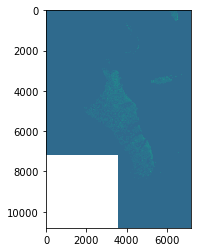

(-79.00013888888888, -76.9998611111111, 22.99986111111111, 26.000138888888888)
BoundingBox(left=-79.00013888888888, bottom=22.99986111111111, right=-76.9998611111111, top=26.000138888888888)


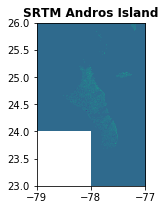

In [6]:
# Explore SRTM attributes and data
print(type(srtm))
print(type(srtm_np))
print(srtm)
print(srtm_np)
print(srtm_np_2d_masked)
print(srtm.shape)
print(srtm_np.shape)
print(srtm_np_2d_masked.shape)

# All the attributes in one
print(srtm.profile)  
print(srtm.meta)
# Individual attributes
print(srtm.bounds)
print(srtm.name)
print(srtm.count)
print(srtm.crs)
print(srtm.res)

# # Plots
# rio.plot.show(srtm)
# rio.plot.show(srtm_np)
rio.plot.show(srtm_np_2d_masked)

fig, ax = plt.subplots(figsize = (8,3))
rio.plot.show(srtm, 
     title="SRTM Andros Island", 
     ax=ax)
# ax.set_axis_off()

# Spatial Extent / bounds
srtm_spatialextent = rio.plot.plotting_extent(srtm) # for matplotlib
print(srtm_spatialextent)
srtm_bounds = srtm.bounds
print(srtm_bounds)

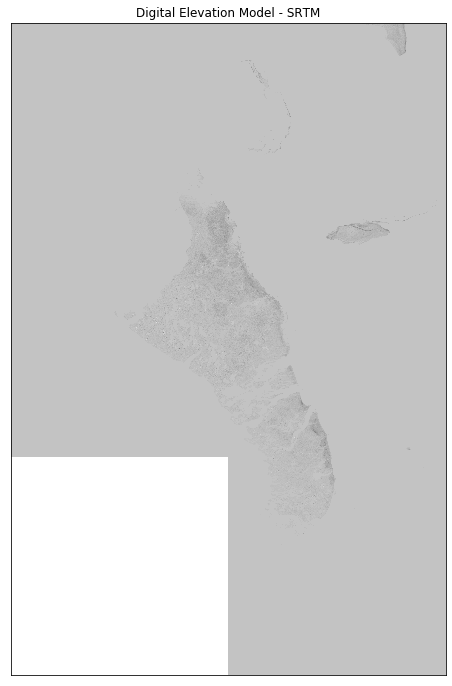

In [7]:
ep.plot_bands(srtm_np_2d_masked,
              cmap='Greys',
              extent=srtm_spatialextent,
              title="Digital Elevation Model - SRTM",
              cbar=False)
plt.show()

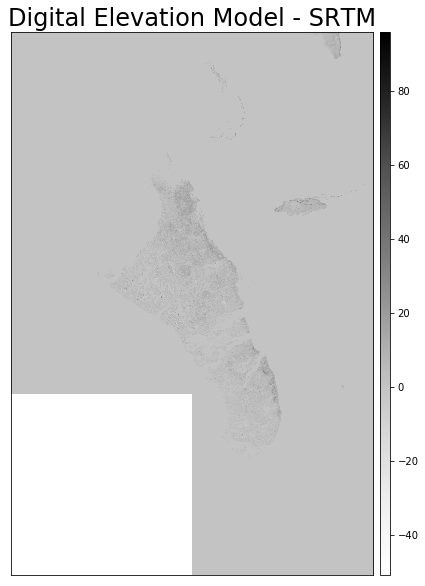

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
ep.plot_bands(srtm_np_2d_masked,
              cmap='Greys',
              extent=srtm_spatialextent,
              scale=False,
              ax=ax)
ax.set_title("Digital Elevation Model - SRTM", fontsize=24)
plt.show()

In [9]:
srtm_np_2d_masked

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., 0, 0, 0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-32768,
  dtype=int16)

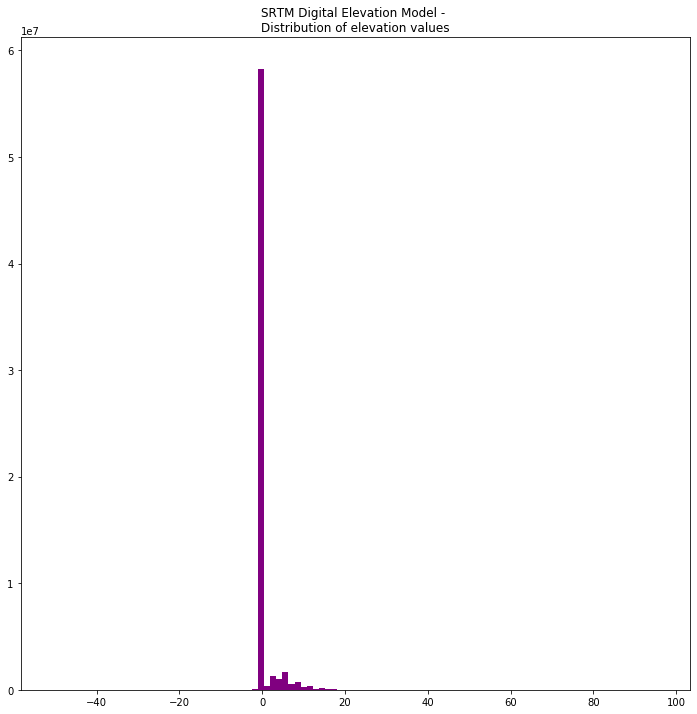

In [10]:
# Plot histogram
ep.hist(srtm_np_2d_masked[~srtm_np_2d_masked.mask].ravel(),
        bins=100,
        title="SRTM Digital Elevation Model - \nDistribution of elevation values")
plt.show()

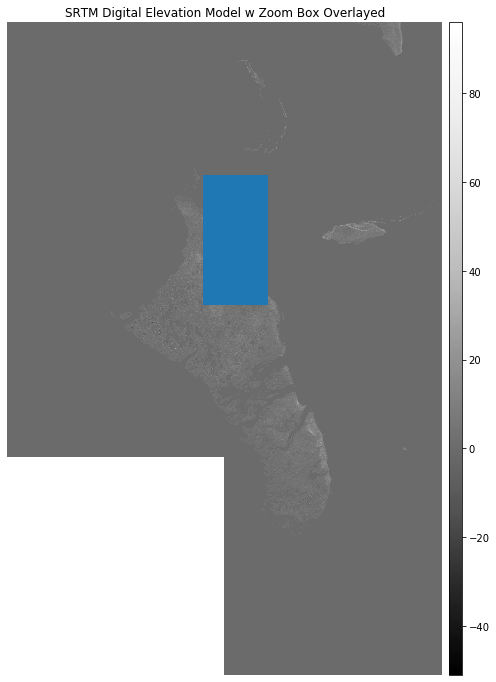

In [11]:
zoomed_extent = [-78.1, 24.7, -77.8, 25.3] # minx, miny, maxx, maxy, ccw=True
# Turn extent into geodataframe
zoom_ext_gdf = gpd.GeoDataFrame()
zoom_ext_gdf.loc[0, 'geometry'] = box(*zoomed_extent)
# Plot the original data with the boundary box
fig, ax = plt.subplots(figsize=(20, 12))
ep.plot_bands(srtm_np_2d_masked,
              extent=srtm_spatialextent,
              title="SRTM Digital Elevation Model w Zoom Box Overlayed",
              ax=ax,
              scale=False)
zoom_ext_gdf.plot(ax=ax)

ax.set_axis_off()

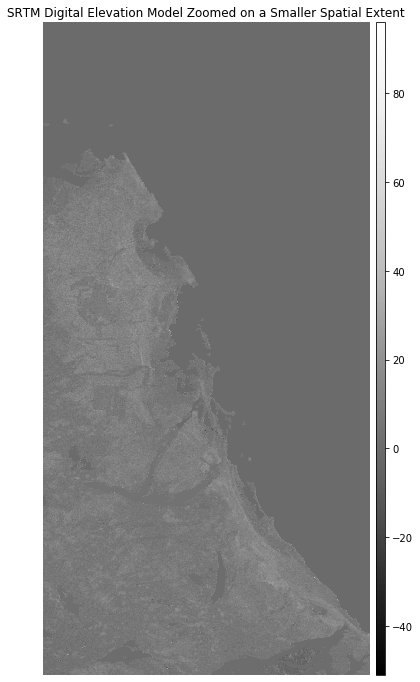

In [12]:
# Plot the data but set the x and y lim with the zoom box
fig, ax = plt.subplots(figsize=(20, 12))
ep.plot_bands(srtm_np_2d_masked,
              extent=srtm_spatialextent,
              title="SRTM Digital Elevation Model Zoomed on a Smaller Spatial Extent",
              ax=ax,
              scale=False)
# Set x and y limits of the plot
ax.set_xlim(zoomed_extent[0], zoomed_extent[2])
ax.set_ylim(zoomed_extent[1], zoomed_extent[3])
ax.set_axis_off()
plt.show()

In [13]:
# CRS manipulation / exploration
srtm_crs = srtm.crs
print(srtm_crs)
print(type(srtm_crs))
srtm_epsg = srtm_crs.to_epsg()
print(srtm_epsg)
srtm_crs2proj4 = srtm_crs.to_proj4()
print(srtm_crs2proj4)
srtm_proj4 = et.epsg[str(srtm_epsg)]
print(srtm_proj4)

EPSG:4326
<class 'rasterio.crs.CRS'>
4326
+init=epsg:4326
+proj=longlat +datum=WGS84 +no_defs


In [14]:
print(srtm_np_2d_masked.shape)
print(srtm_np_2d_masked.ravel().shape)

(10801, 7201)
(77778001,)


[0 0 0 ... 0 0 0]


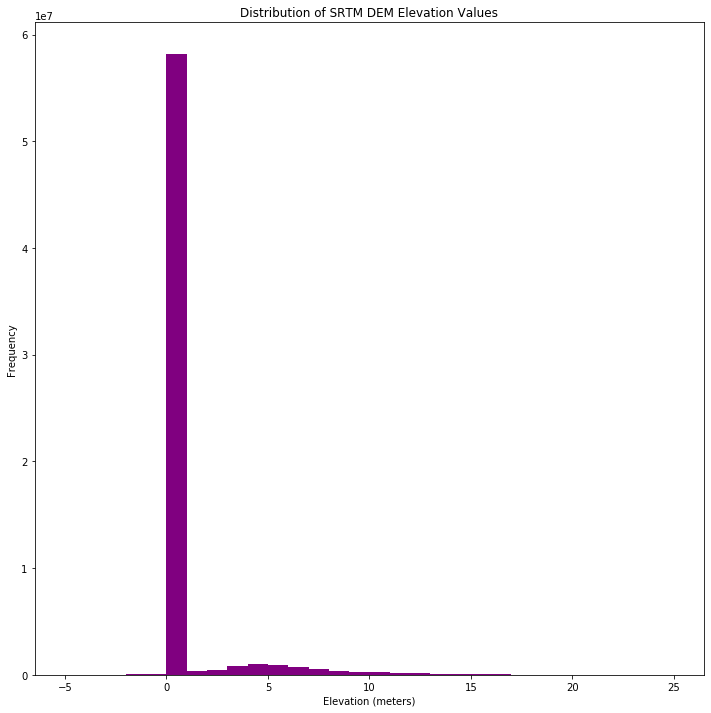

In [15]:
# SRTM Histogram with smaller extent
print(srtm_np_2d_masked.ravel())
ep.hist(srtm_np_2d_masked, colors=['purple'],
        bins = 30,
        hist_range = (-5, 25),
        title="Distribution of SRTM DEM Elevation Values",
        xlabel='Elevation (meters)',
        ylabel='Frequency'),

plt.show()

In [16]:

srtm.profile

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 7201, 'height': 10801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
       0.0, -0.0002777777777777778, 26.000138888888888), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

In [17]:
srtm.meta

{'driver': 'VRT',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 7201,
 'height': 10801,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
        0.0, -0.0002777777777777778, 26.000138888888888)}

In [18]:
# Explore gliht data
# DTM
with rio.open(glihtdtm_source, 'r+') as dtm_src:
    dtm_src.nodata = -2147483648.0
    print(dtm_src.nodata)
    # Get some metadata and boundary info
    dtm_meta = dtm_src.meta
    dtm_bounds = dtm_src.bounds # rasterio bounds format
    dtm_spatialextent = rio.plot.plotting_extent(dtm_src)# for matplotlib
    glihtdtm_np = dtm_src.read(1)  # as NumPy array
    glihtdtm_np_2d_masked = dtm_src.read(1, masked=True) # 1 forces 2D array, masked changes all nodata values to nan
    print(dtm_src.meta)
    print(dtm_src.nodata)
print(glihtdtm_np_2d_masked)
print(glihtdtm_np)
# No data value doesn't seem to be working like the SRTM
# Set DTM values of 0 to NAN (no data or not a number)
glihtdtm_np_2d_masked[glihtdtm_np_2d_masked == -2147483648.0] = np.nan
print(glihtdtm_np_2d_masked)

-2147483648.0
{'driver': 'VRT', 'dtype': 'float32', 'nodata': -2147483648.0, 'width': 34458, 'height': 96679, 'count': 1, 'crs': CRS.from_epsg(32617), 'transform': Affine(1.0, 0.0, 788550.0,
       0.0, -1.0, 2787862.0)}
-2147483648.0
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[[-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
  -2.1474836e+09 -2.1474836e+09]
 [-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
  -2.1474836e+09 -2.1474836e+09]
 [-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
  -2.1474836e+09 -2.1474836e+09]
 ...
 [-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
  -2.1474836e+09 -2.1474836e+09]
 [-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
  -2.1474836e+09 -2.1474836e+09]
 [-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
  -2.1474836e+09 -2.1474836e+09]]
[[-- -- -

In [19]:
glihtdtm_np_2d_masked = np.ma.masked_values(glihtdtm_np, -2147483648.0)
print(glihtdtm_np_2d_masked)
# Not sure why this doesn't have the same structure as SRTM masked array (data=[] and mask=[])

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


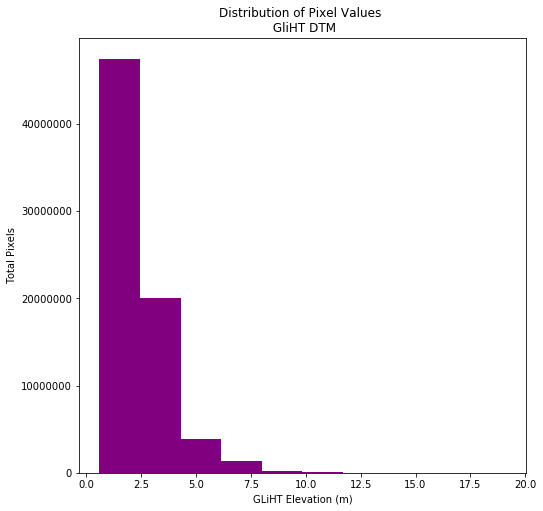

In [20]:
# GliHT data
# Load & plot the data

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(glihtdtm_np_2d_masked.ravel(),
        color="purple")
ax.set(xlabel="GLiHT Elevation (m)",
       ylabel="Total Pixels",
       title="Distribution of Pixel Values \n GliHT DTM")

# Turn off scientific notation
ax.ticklabel_format(useOffset=False,
                    style='plain')
# Throwing RunTimeWarning about invalid value  - no error after creating mask value

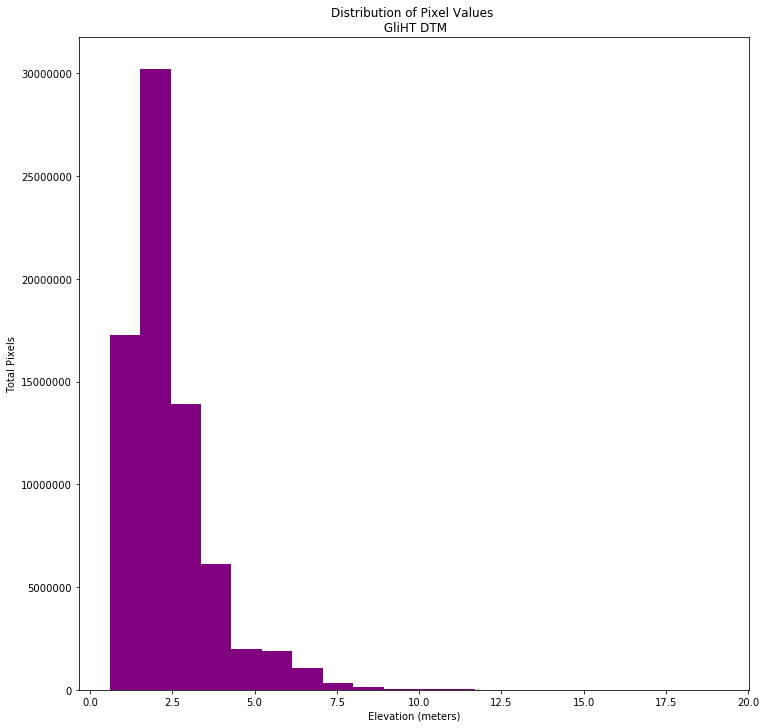

In [21]:
# Histogram of GliHT using earthpy library -- don't have to use "ravel"
fig,ax = ep.hist(glihtdtm_np_2d_masked, colors=['purple'],
        title="Distribution of Pixel Values \n GliHT DTM",
        xlabel='Elevation (meters)',
        ylabel='Total Pixels')
# Turn off scientific notation
ax.ticklabel_format(useOffset=False,
                    style='plain')
plt.show()

In [22]:
print('Mean:', glihtdtm_np_2d_masked.mean())
print('Max:', glihtdtm_np_2d_masked.max())
print('Min:', glihtdtm_np_2d_masked.min())

Mean: 2.404261784032093
Max: 19.09023
Min: 0.5987841


In [23]:
# CHM
with rio.open(glihtchm_source, 'r+') as chm_src:
    print(chm_src.nodata)
    # Get some metadata and boundary info
    chm_meta = chm_src.meta
    chm_bounds = chm_src.bounds # rasterio bounds format
    chm_spatialextent = rio.plot.plotting_extent(chm_src)# for matplotlib
    glihtchm_np = chm_src.read(1)  # as NumPy array
    glihtchm_np_2d_masked = chm_src.read(1, masked=True) # 1 forces 2D array, masked changes all nodata values to nan
# Since no data isn't working as expected for GLiHT, explicitly mask that value
glihtchm_np_2d_masked = np.ma.masked_values(glihtchm_np, -2147483648.0)
print(glihtchm_np_2d_masked)

-2147483648.0
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


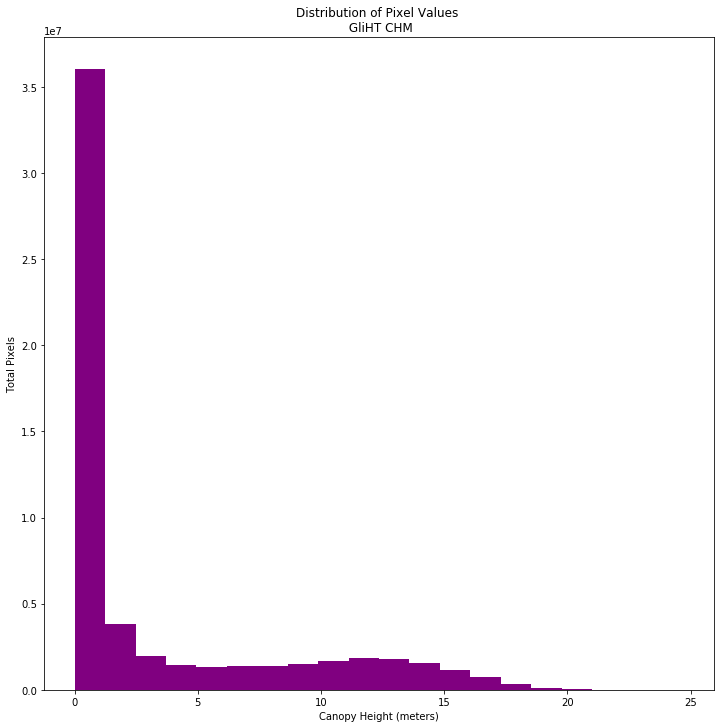

In [24]:
ep.hist(glihtchm_np_2d_masked, colors=['purple'],
        title="Distribution of Pixel Values \n GliHT CHM",
        xlabel='Canopy Height (meters)',
        ylabel='Total Pixels'),
plt.show()

In [25]:
print('Mean:', glihtchm_np_2d_masked.mean())
print('Max:', glihtchm_np_2d_masked.max())
print('Min:', glihtchm_np_2d_masked.min())

Mean: 3.2339060858494
Max: 24.71
Min: -1.8189894e-12


In [26]:
# Get a digital surface model (bare earth terrain, DTm plus the canopy height model CHM)
glihtdsm = glihtchm_np_2d_masked + glihtdtm_np_2d_masked

In [27]:
print('Mean:', glihtdsm.mean())
print('Max:', glihtdsm.max())
print('Min:', glihtdsm.min())

Mean: 5.809026318888251
Max: 30.990908
Min: 0.63464373


In [28]:
type(glihtdsm)

numpy.ma.core.MaskedArray

In [29]:
glihtdsm

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-2147483600.0,
  dtype=float32)

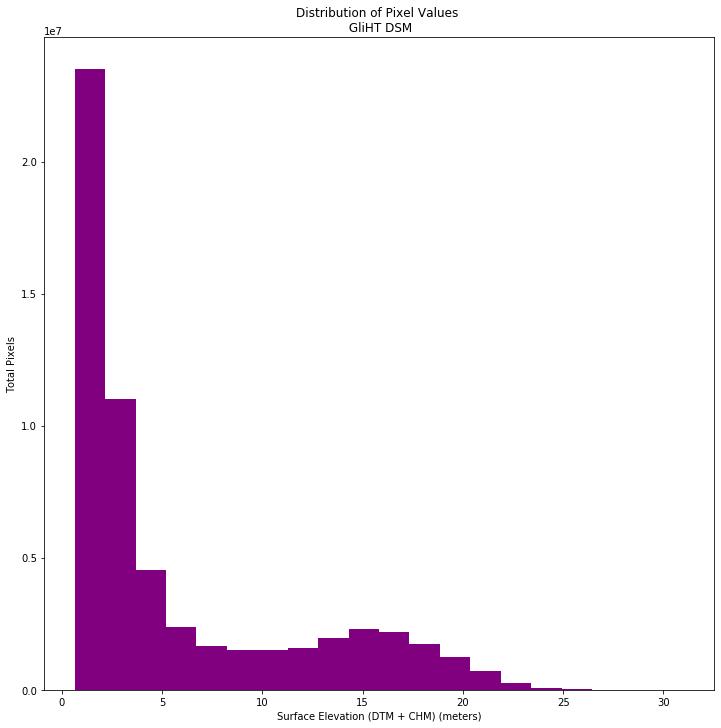

In [30]:
ep.hist(glihtdsm, colors=['purple'],
        title="Distribution of Pixel Values \n GliHT DSM",
        xlabel='Surface Elevation (DTM + CHM) (meters)',
        ylabel='Total Pixels'),
plt.show()

In [31]:
chm_meta

{'driver': 'VRT',
 'dtype': 'float32',
 'nodata': -2147483648.0,
 'width': 34458,
 'height': 96679,
 'count': 1,
 'crs': CRS.from_epsg(32617),
 'transform': Affine(1.0, 0.0, 788550.0,
        0.0, -1.0, 2787862.0)}

In [32]:
chm_bounds

BoundingBox(left=788550.0, bottom=2691183.0, right=823008.0, top=2787862.0)

In [33]:
# Export DSM as GeoTiff
dsm_nodatavalue = -2147483648.0
dsm_meta = chm_meta.copy()
dsm_meta.update({
    'nodata': dsm_nodatavalue,
    'driver': 'GTiff'
})
glihtdsm_fi = np.ma.filled(glihtdsm, fill_value=dsm_nodatavalue)
dsm_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -2147483648.0,
 'width': 34458,
 'height': 96679,
 'count': 1,
 'crs': CRS.from_epsg(32617),
 'transform': Affine(1.0, 0.0, 788550.0,
        0.0, -1.0, 2787862.0)}

In [34]:
# New path for the output file
glihtdsm_path = os.path.join(work_dir,'Andros_May2015_DSM.tif' )
with rio.open(glihtdsm_path, 'w', **dsm_meta) as outf:
    outf.write(glihtdsm_fi, 1)

In [35]:
# Reproject the SRTM to same CRS as the GLiHT data, UTM 17-N
srtm_vrt_reproj = 'SRTM30m_Andros_epsg32617.vrt'
with rio.open(srtm_source) as src:
    with rio.vrt.WarpedVRT(src, 
                           crs='epsg:32617', 
                           resampling=rio.enums.Resampling.nearest, 
                           dest_resolution = (30.0,30.0)) as vrt:
        rio.shutil.copy(vrt, srtm_vrt_reproj, driver='VRT')
        print(vrt.meta)
    print(src.meta)

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 6998, 'height': 11227, 'count': 1, 'crs': CRS.from_epsg(32617), 'transform': Affine(30.010411424881553, 0.0, 700166.3997236808,
       0.0, -30.010411424881553, 2881834.922152516)}
{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 7201, 'height': 10801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
       0.0, -0.0002777777777777778, 26.000138888888888)}


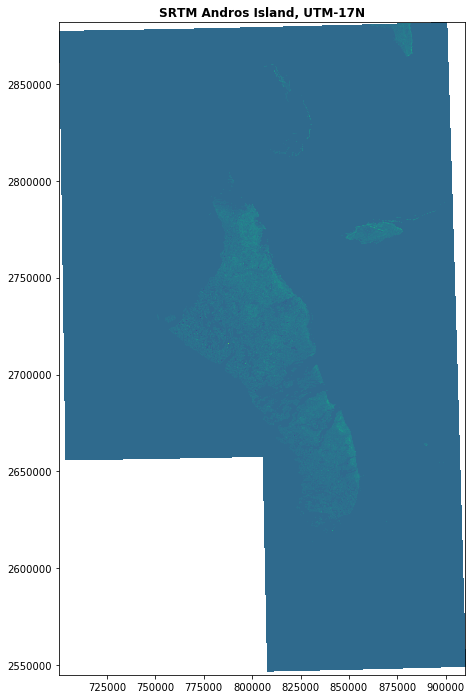

In [36]:
fig, ax = plt.subplots(figsize = (20,12))
with rio.open(srtm_vrt_reproj) as src:
    rio.plot.show(src, 
         title="SRTM Andros Island, UTM-17N", 
         ax=ax)

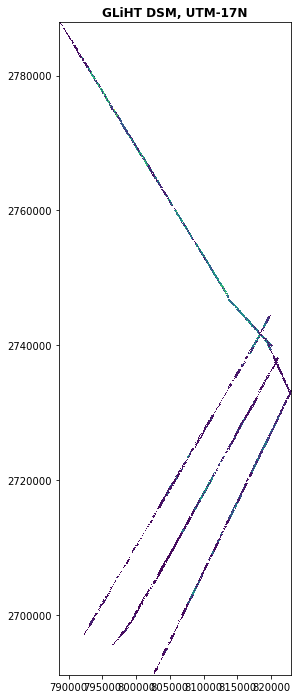

In [37]:
fig, ax = plt.subplots(figsize = (20,12))
with rio.open(glihtdsm_path) as src:
    rio.plot.show(src, 
         title="GLiHT DSM, UTM-17N", 
         ax=ax)

In [38]:
# Create a SRTM extent raster with unique ID for each SRTM cell
with rio.open(srtm_vrt_reproj) as src:
    rows, cols = src.shape
    print(rows, cols)
    unique_raster = np.arange(rows * cols).reshape(rows, cols)
unique_raster

11227 6998


array([[       0,        1,        2, ...,     6995,     6996,     6997],
       [    6998,     6999,     7000, ...,    13993,    13994,    13995],
       [   13996,    13997,    13998, ...,    20991,    20992,    20993],
       ...,
       [78545552, 78545553, 78545554, ..., 78552547, 78552548, 78552549],
       [78552550, 78552551, 78552552, ..., 78559545, 78559546, 78559547],
       [78559548, 78559549, 78559550, ..., 78566543, 78566544, 78566545]])

In [39]:
# Get GLiHT into a masked numpy array and store the metadata
with rio.open(glihtdsm_path) as src:
    glihtdsm_np = src.read(1, masked=True)
    glihtdsm_meta = src.meta
    glihtdsm_bounds = src.bounds # rasterio bounds format
    glihtdsm_spatialextent = rio.plot.plotting_extent(src)# for matplotlib
    # example of getting coordinate with an input index
    (x,y) = src.xy(src.height // 2, src.width // 2)
    print(x,y)
#     x1, y1 = (src.bounds.left + 100000, src.bounds.top - 50000)
    row, col = src.index(x, y)
    print(row, col)
    print(glihtdsm_np[row][col])
    # example of value at coordinate
    
# print(glihtdsm_np)
# print(glihtdsm_meta)
# print(glihtdsm_meta['transform'])
# print(glihtdsm_meta['nodata'])
# print(glihtdsm_bounds)
# print(glihtdsm_spatialextent)
    


805779.5 2739522.5
48339 17229
--


In [40]:
gliht_data = glihtdsm_np.data[0]
print(glihtdsm_np)
print(gliht_data)
gliht_nodata = glihtdsm_meta['nodata']
print(gliht_nodata)
# # extract the row, columns of the valid values
# row, col = np.where(gliht_data != gliht_nodata) 
np.where(gliht_data != gliht_nodata) 

# elev = np.extract(gliht_data != gliht_nodata, gliht_data)
# type(gliht_data)
# print(elev)


[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[-2.1474836e+09 -2.1474836e+09 -2.1474836e+09 ... -2.1474836e+09
 -2.1474836e+09 -2.1474836e+09]
-2147483648.0


(array([], dtype=int64),)

In [41]:
gliht_data

array([-2.1474836e+09, -2.1474836e+09, -2.1474836e+09, ...,
       -2.1474836e+09, -2.1474836e+09, -2.1474836e+09], dtype=float32)

In [42]:


print(glihtdsm_spatialextent[0])
print(glihtdsm_spatialextent[3])

x, y = (glihtdsm_spatialextent[0] + 100000, glihtdsm_spatialextent[3] - 50000)
# row, col = glihtdsm_spatialextent.index(x, y)

788550.0
2787862.0


In [43]:
glihtdsm_np.shape

(96679, 34458)

In [44]:
glihtdsm_np.ndim

2

In [45]:
# Value at index 0,0
glihtdsm_np[0][0]

masked

In [46]:
# Arrays of all the indices 
ri, ci = np.ma.indices(glihtdsm_np.shape)
print(ri)
print(ci)

[[    0     0     0 ...     0     0     0]
 [    1     1     1 ...     1     1     1]
 [    2     2     2 ...     2     2     2]
 ...
 [96676 96676 96676 ... 96676 96676 96676]
 [96677 96677 96677 ... 96677 96677 96677]
 [96678 96678 96678 ... 96678 96678 96678]]
[[    0     1     2 ... 34455 34456 34457]
 [    0     1     2 ... 34455 34456 34457]
 [    0     1     2 ... 34455 34456 34457]
 ...
 [    0     1     2 ... 34455 34456 34457]
 [    0     1     2 ... 34455 34456 34457]
 [    0     1     2 ... 34455 34456 34457]]


In [47]:
# Just valid values from the input masked array
glihtdsm_np.compressed()

array([1.586909 , 1.5345211, 1.539167 , ..., 1.2938448, 1.3294634,
       1.3661268], dtype=float32)

In [ ]:
# indices of masked values
np.where(glihtdsm_np)

In [ ]:
# Row and column indices of valid values from the masked array
rows, cols = np.where(~glihtdsm_np.mask)
print(rows)
print(cols)

In [ ]:
# List of index tuples for each valid value
indices = list(zip(rows, cols))